In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project I | Deep Learning: Image Classification with CNN

##Datasets

We will work with the Animals-10 dataset (https://www.kaggle.com/datasets/alessiocorrado99/animals10/code)

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from tensorflow.keras.applications import VGG16, EfficientNetB0
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

#1. Data Preprocessing

In [ ]:
# Define your source and destination directories
nico_dir = '/content/drive/MyDrive/Ironhack/week3/Animals-10/raw-img'
output_dir = '/content/presplit_data'

# Define the split ratios
train_split = 0.8  # 80% for training
val_split = 0.2    # 20% for validation

# Create the new directory structure if it doesn't exist
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'validation'), exist_ok=True)

# Get a list of all class folders (your labels)
class_folders = [f for f in os.listdir(nico_dir) if os.path.isdir(os.path.join(nico_dir, f))]

# Iterate through each class folder
for class_name in class_folders:
    # Create class subdirectories in train and validation folders
    os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'validation', class_name), exist_ok=True)

    # Get all the image files for the current class
    class_path = os.path.join(nico_dir, class_name)
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle the list of images to ensure a random split
    random.shuffle(images)

    # Calculate the number of images for training and validation
    train_count = int(len(images) * train_split)

    # Split the images
    train_images = images[:train_count]
    val_images = images[train_count:]

    # Copy files to the new directories
    print(f"Splitting class: {class_name}")
    for img_path in train_images:
        shutil.copy(img_path, os.path.join(output_dir, 'train', class_name, os.path.basename(img_path)))

    for img_path in val_images:
        shutil.copy(img_path, os.path.join(output_dir, 'validation', class_name, os.path.basename(img_path)))

print("Data splitting complete!")

Splitting class: pecora
Splitting class: ragno
Splitting class: gatto
Splitting class: elefante
Splitting class: gallina
Splitting class: farfalla
Splitting class: cavallo
Splitting class: mucca
Splitting class: cane
Splitting class: scoiattolo
Data splitting complete!


In [ ]:
train_dir = '/content/presplit_data/train'
val_dir = '/content/presplit_data/validation'

In [ ]:
# Mapping from Italian to English
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno" : "spider"
}

# List of directories to process
directories_to_process = [train_dir, val_dir]

for current_base_dir in directories_to_process:
    print(f"--- Processing directory: {current_base_dir} ---")

    # Iterate through all items in the current directory
    for folder_name in os.listdir(current_base_dir):
        # Check if the item is a directory
        current_path = os.path.join(current_base_dir, folder_name)
        if os.path.isdir(current_path):
            # Check if the folder name is in our translation dictionary
            if folder_name in translate:
                new_folder_name = translate[folder_name]
                new_path = os.path.join(current_base_dir, new_folder_name)

                # Rename the folder
                os.rename(current_path, new_path)
                print(f"Renamed '{folder_name}' to '{new_folder_name}'")
            else:
                print(f"Skipping folder '{folder_name}' as no translation was found.")

    print(f"--- Finished processing {current_base_dir} ---")

print("\nAll specified folders have been renamed.")

--- Processing directory: /content/presplit_data/train ---
Renamed 'gallina' to 'chicken'
Renamed 'pecora' to 'sheep'
Renamed 'cavallo' to 'horse'
Renamed 'cane' to 'dog'
Renamed 'gatto' to 'cat'
Renamed 'scoiattolo' to 'squirrel'
Renamed 'ragno' to 'spider'
Renamed 'elefante' to 'elephant'
Renamed 'farfalla' to 'butterfly'
Renamed 'mucca' to 'cow'
--- Finished processing /content/presplit_data/train ---
--- Processing directory: /content/presplit_data/validation ---
Renamed 'gallina' to 'chicken'
Renamed 'pecora' to 'sheep'
Renamed 'cavallo' to 'horse'
Renamed 'cane' to 'dog'
Renamed 'gatto' to 'cat'
Renamed 'scoiattolo' to 'squirrel'
Renamed 'ragno' to 'spider'
Renamed 'elefante' to 'elephant'
Renamed 'farfalla' to 'butterfly'
Renamed 'mucca' to 'cow'
--- Finished processing /content/presplit_data/validation ---

All specified folders have been renamed.


In [ ]:
IMG_SIZE = (64,64)
batch_size = 64
class_names = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

# Normalize and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.1,
    horizontal_flip=True, # this helps the model learn the animals and not rotations of the image or other unwanted features
    vertical_flip=False, # animals usually don't stand on their heads
)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    classes= class_names,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    classes= class_names,
)


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


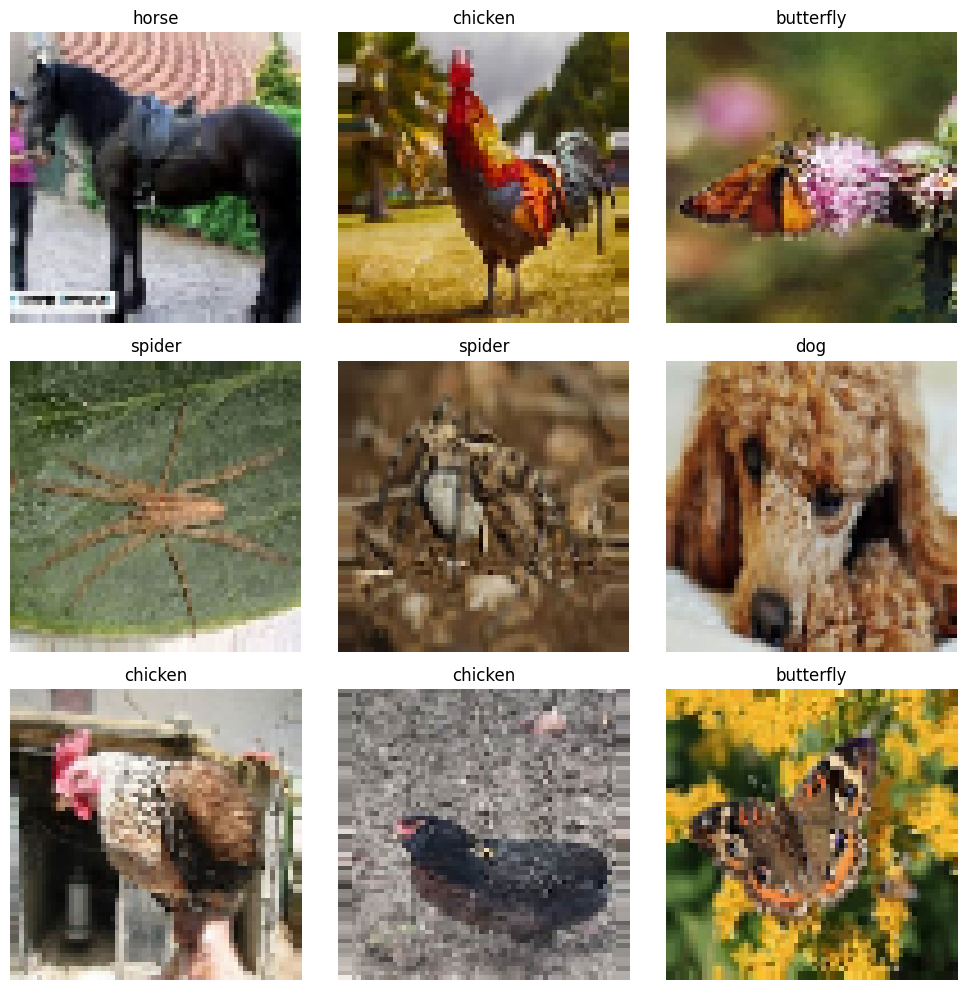

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

#5. Transfer Learning

We chose VGG16 for transfer learning because it’s a well-known model that performs well on image classification tasks. It’s pretrained on ImageNet, meaning it has already learned useful features from a large dataset of images, including animals. This makes it a good starting point for our own task. VGG16 is also simple to understand and modify, and it strikes a good balance between accuracy and computational efficiency, making it suitable for environments like Google Colab.

In [ ]:
K.clear_session()

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
transfer_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,802 (58.14 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_vgg = transfer_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - accuracy: 0.4480 - loss: 1.6016 - val_accuracy: 0.6062 - val_loss: 1.1530
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 57s 173ms/step - accuracy: 0.5801 - loss: 1.2023 - val_accuracy: 0.6258 - val_loss: 1.1022
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 60s 182ms/step - accuracy: 0.6072 - loss: 1.1313 - val_accuracy: 0.6392 - val_loss: 1.0488
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 54s 165ms/step - accuracy: 0.6286 - loss: 1.0801 - val_accuracy: 0.6560 - val_loss: 1.0110
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 54s 164ms/step - accuracy: 0.6474 - loss: 1.0275 - val_accuracy: 0.6459 - val_loss: 1.0417


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━

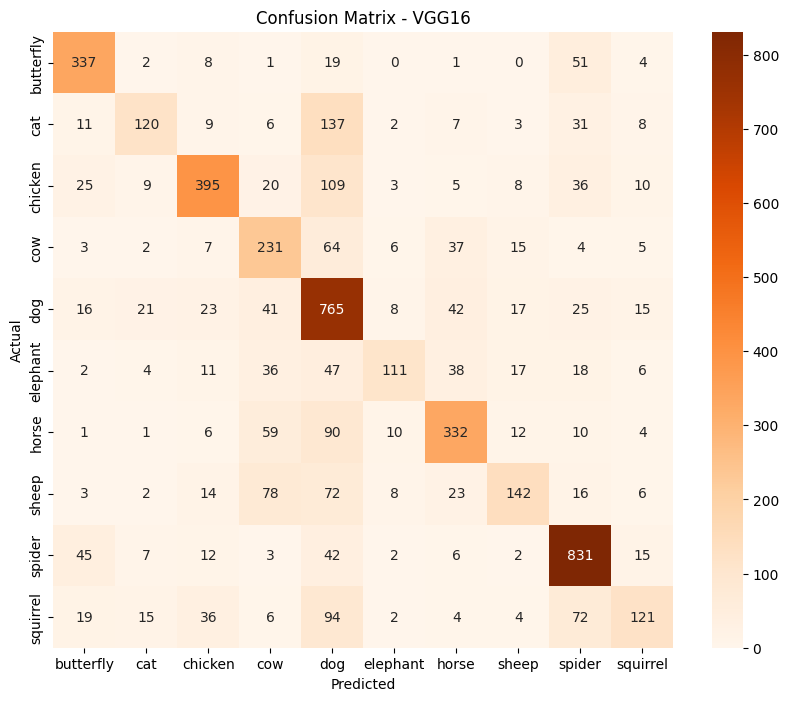

In [ ]:
# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = transfer_model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16")
plt.show()


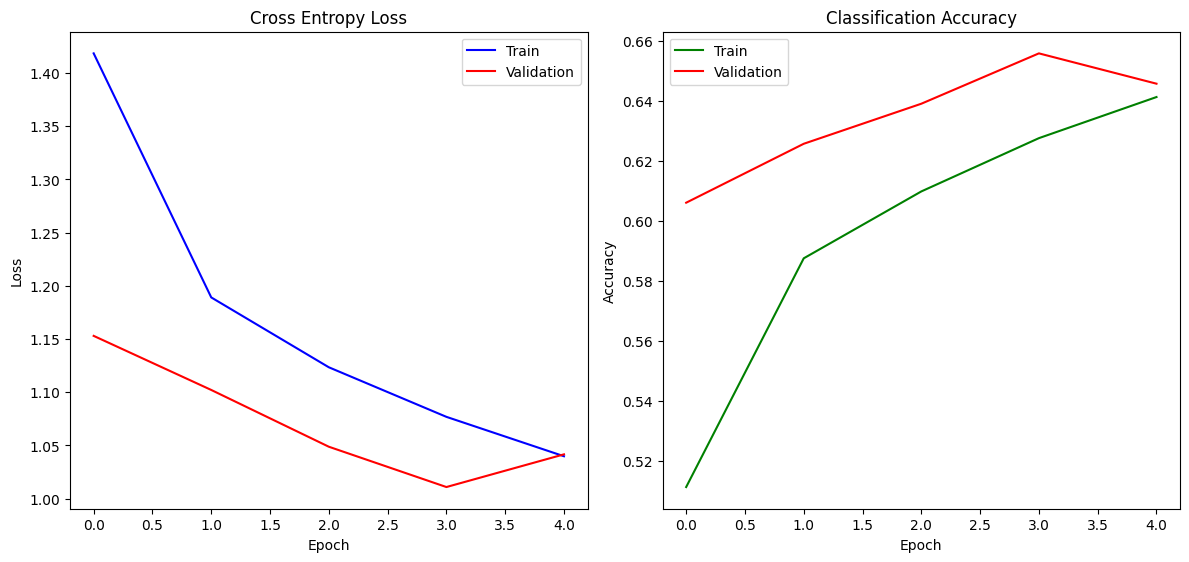

In [ ]:
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history_vgg.history['loss'], color='blue', label='Train')
plt.plot(history_vgg.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history_vgg.history['accuracy'], color='green', label='Train')
plt.plot(history_vgg.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

1. Unfroze first layer, to retrain on our dataset


In [ ]:
K.clear_session()

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
# Unfreeze the first convolutional block of the VGG16 model
blocks_to_unfreeze = ['block1', 'block2', 'block3', 'block4', 'block5']
for layer in base_model.layers:
    if any(layer.name.startswith(block) for block in blocks_to_unfreeze):
        layer.trainable = True
    else:
        layer.trainable = False


transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
transfer_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,802 (58.14 MB)

 Trainable params: 15,241,802 (58.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_frozen_vgg = transfer_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 89s 223ms/step - accuracy: 0.2127 - loss: 2.2060 - val_accuracy: 0.3772 - val_loss: 1.8520
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 59s 180ms/step - accuracy: 0.3646 - loss: 1.8862 - val_accuracy: 0.4205 - val_loss: 1.6786
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 60s 183ms/step - accuracy: 0.4240 - loss: 1.6802 - val_accuracy: 0.4808 - val_loss: 1.4865
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 59s 180ms/step - accuracy: 0.4707 - loss: 1.5075 - val_accuracy: 0.5033 - val_loss: 1.3952
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 64s 196ms/step - accuracy: 0.5195 - loss: 1.3853 - val_accuracy: 0.5514 - val_loss: 1.2773
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 59s 181ms/step - accuracy: 0.5548 - loss: 1.2966 - val_accuracy: 0.5461 - val_loss: 1.2930
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.5834 - loss: 1.2182 - val_accuracy: 0.5940 - val_loss: 1.1612
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 59s 180ms/step - accuracy: 0.6047 - loss: 1

In [ ]:
# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = transfer_model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━

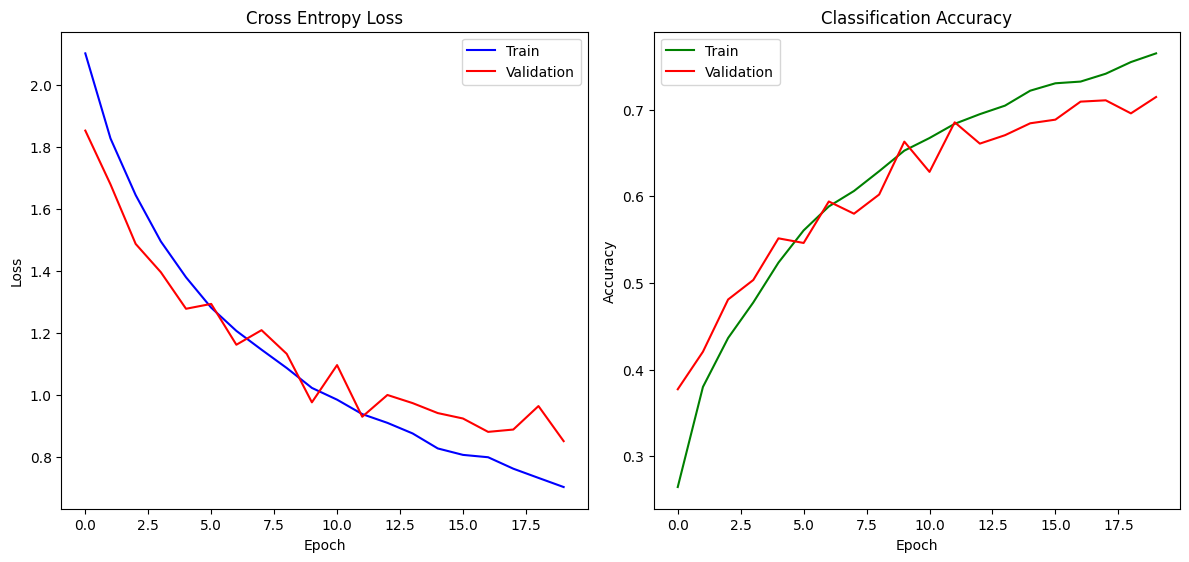

In [ ]:
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history_frozen_vgg.history['loss'], color='blue', label='Train')
plt.plot(history_frozen_vgg.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history_frozen_vgg.history['accuracy'], color='green', label='Train')
plt.plot(history_frozen_vgg.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

The Transfer Learning Model VGG16 that we used has great potential for more
improvements, but our results are humbling.
This might be an issue with class imbalances.

In [ ]:
transfer_model.save('model_vgg.keras')

In [ ]:
IMG_SIZE = (128,128)
batch_size = 32

# Normalize and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.1,
    horizontal_flip=True, # this helps the model learn the animals and not rotations of the image or other unwanted features
    vertical_flip=False, # animals usually don't stand on their heads
)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


In [ ]:
# --- Transfer Learning Model (Improved) ---
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze all layers in the base model initially
base_model.trainable = False

# Unfreeze only the last few blocks for fine-tuning
# This prevents destroying the low-level features learned on ImageNet
print("Unfreezing block5 for fine-tuning...")
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
        print(f"  - Layer {layer.name} is now trainable.")

transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

# Use a significantly lower learning rate for fine-tuning
# This prevents the pre-trained weights from being destroyed
transfer_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

# --- Callbacks for Improved Training ---
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

Unfreezing block5 for fine-tuning...
  - Layer block5_conv1 is now trainable.
  - Layer block5_conv2 is now trainable.
  - Layer block5_conv3 is now trainable.
  - Layer block5_pool is now trainable.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,814,666 (64.14 MB)

 Trainable params: 9,179,402 (35.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# --- Training the Model ---
# Train for more epochs, but early stopping will handle when to stop
print("\nStarting training with fine-tuning and early stopping...")
history_improved = transfer_model.fit(
    train_generator,
    epochs=50,  # Increased epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Starting training with fine-tuning and early stopping...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 133s 194ms/step - accuracy: 0.4626 - loss: 1.5785 - val_accuracy: 0.7745 - val_loss: 0.6884
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 122s 186ms/step - accuracy: 0.7609 - loss: 0.7244 - val_accuracy: 0.8185 - val_loss: 0.5587
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 130s 199ms/step - accuracy: 0.8138 - loss: 0.5629 - val_accuracy: 0.8359 - val_loss: 0.5046
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 118s 181ms/step - accuracy: 0.8437 - loss: 0.4741 - val_accuracy: 0.8441 - val_loss: 0.4786
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.8681 - loss: 0.4080 - val_accuracy: 0.8579 - val_loss: 0.4354
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 118s 180ms/step - accuracy: 0.8801 - loss: 0.3610 - val_accuracy: 0.8573 - val_loss: 0.4313
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 182ms/step - accuracy: 0.8989 - loss: 0.3070 - val_accuracy: 0.8655 - val_loss: 0.4256
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.9102 -


--- Model Evaluation after Fine-tuning ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

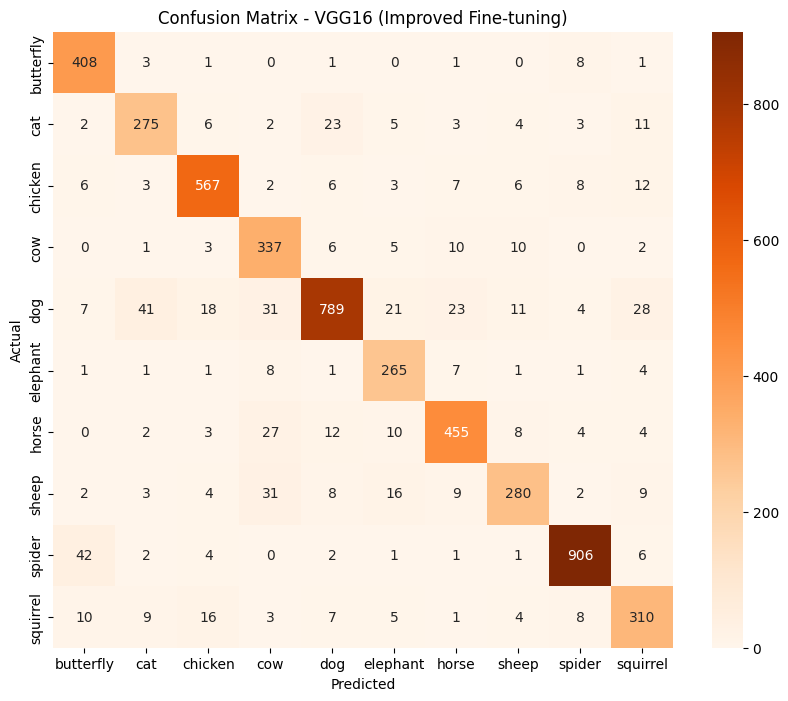

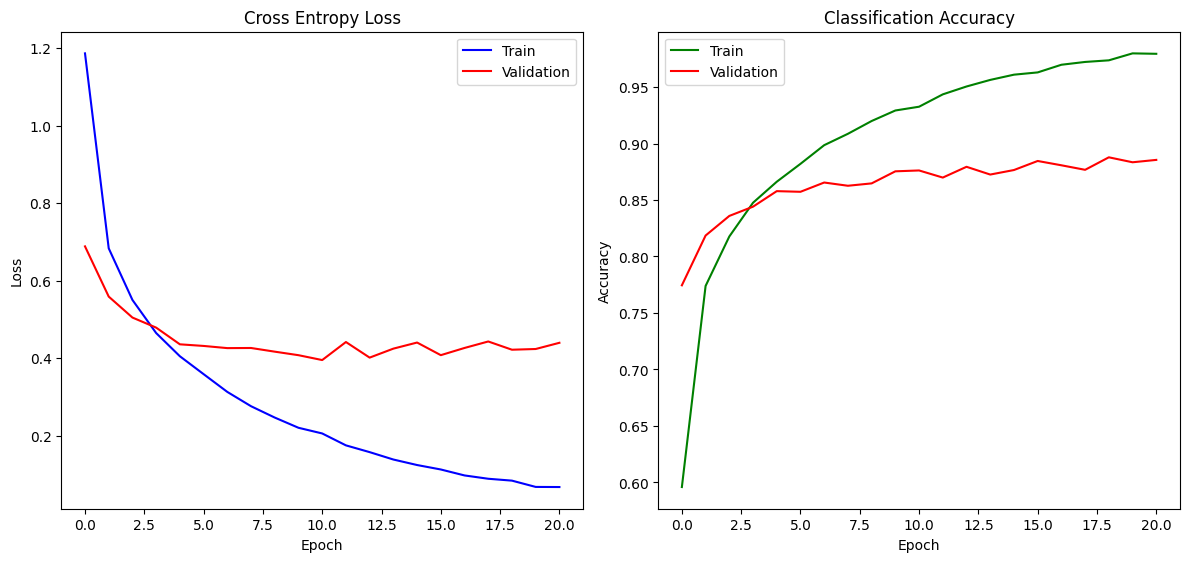

In [ ]:
# --- Evaluation and Visualization ---
print("\n--- Model Evaluation after Fine-tuning ---")

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = transfer_model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 (Improved Fine-tuning)")
plt.show()

# --- Plotting Training History ---
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history_improved.history['loss'], color='blue', label='Train')
plt.plot(history_improved.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history_improved.history['accuracy'], color='green', label='Train')
plt.plot(history_improved.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
transfer_model.save('model_vgg.keras')

In [ ]:
IMG_SIZE = (128,128)
batch_size = 64

# Normalize and augment data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.1,
    horizontal_flip=True, # this helps the model learn the animals and not rotations of the image or other unwanted features
    vertical_flip=False, # animals usually don't stand on their heads
)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


In [ ]:
K.clear_session()

In [ ]:
# --- Transfer Learning Model (Improved) ---
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze all layers in the base model initially
base_model.trainable = False

# Unfreeze the last two blocks for fine-tuning
# This prevents destroying the low-level features learned on ImageNet
for layer in base_model.layers:
    if layer.name.startswith('block4') or layer.name.startswith('block5'):
        layer.trainable = True

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Changed from Flatten()
    Dense(128, activation='relu'), # reduced dense layer
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

# Use a significantly lower learning rate for fine-tuning
# This prevents the pre-trained weights from being destroyed
transfer_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

# --- Callbacks for Improved Training ---
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


# Compute class weights from training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))

# --- Training the Model ---
# Train for more epochs, but early stopping will handle when to stop
history_improved = transfer_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# --- Evaluation and Visualization ---
print("\n--- Model Evaluation after Fine-tuning ---")

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = transfer_model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 13,046,154 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4610 - loss: 1.5414

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 143s 419ms/step - accuracy: 0.4615 - loss: 1.5401 - val_accuracy: 0.8231 - val_loss: 0.5408
Epoch 2/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 129s 394ms/step - accuracy: 0.8108 - loss: 0.5774 - val_accuracy: 0.8443 - val_loss: 0.4704
Epoch 3/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 130s 397ms/step - accuracy: 0.8716 - loss: 0.3911 - val_accuracy: 0.8899 - val_loss: 0.3488
Epoch 4/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 130s 397ms/step - accuracy: 0.9092 - loss: 0.2845 - val_accuracy: 0.8933 - val_loss: 0.3459
Epoch 5/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 134s 373ms/step - accuracy: 0.9191 - loss: 0.2384 - val_accuracy: 0.8720 - val_loss: 0.4186
Epoch 6/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 122s 372ms/step - accuracy: 0.9382 - loss: 0.1881 - val_accuracy: 0.8886 - val_loss: 0.3938
Epoch 7/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 123s 375ms/step - accuracy: 0.9509 - loss: 0.1539 - val_accuracy: 0.8947 - val_loss: 0.3836
Epoch 8/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 123s 374ms/step - accuracy: 0.9578 - loss: 0.11

Precision: 0.8908
Recall: 0.9069
F1 Score: 0.8972
              precision    recall  f1-score   support

   butterfly       0.83      0.97      0.89       423
         cat       0.92      0.86      0.89       334
     chicken       0.94      0.91      0.93       620
         cow       0.82      0.90      0.86       374
         dog       0.93      0.87      0.90       973
    elephant       0.85      0.96      0.90       290
       horse       0.90      0.91      0.91       525
       sheep       0.89      0.85      0.87       364
      spider       0.98      0.92      0.95       965
    squirrel       0.84      0.90      0.87       373

    accuracy                           0.90      5241
   macro avg       0.89      0.91      0.90      5241
weighted avg       0.91      0.90      0.91      5241



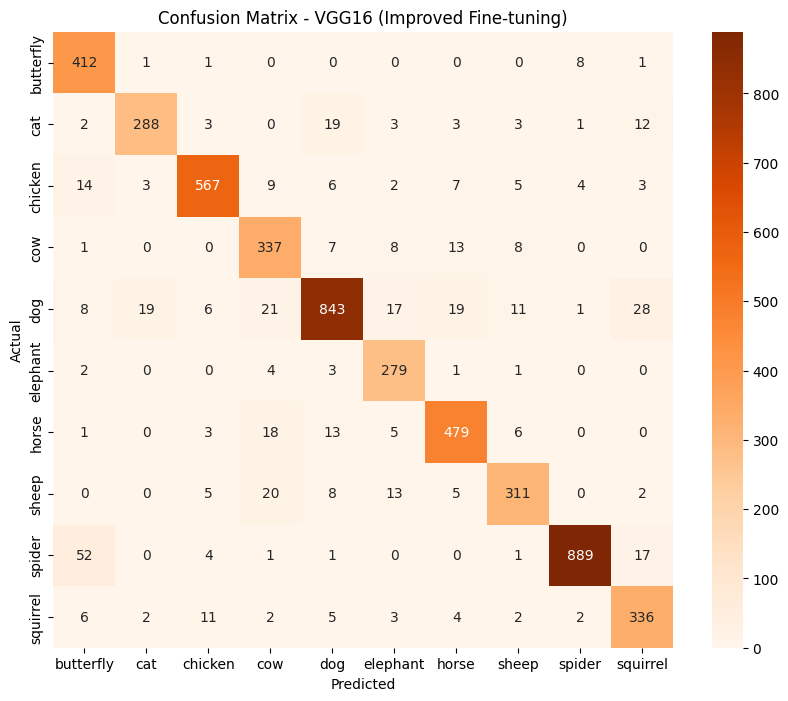

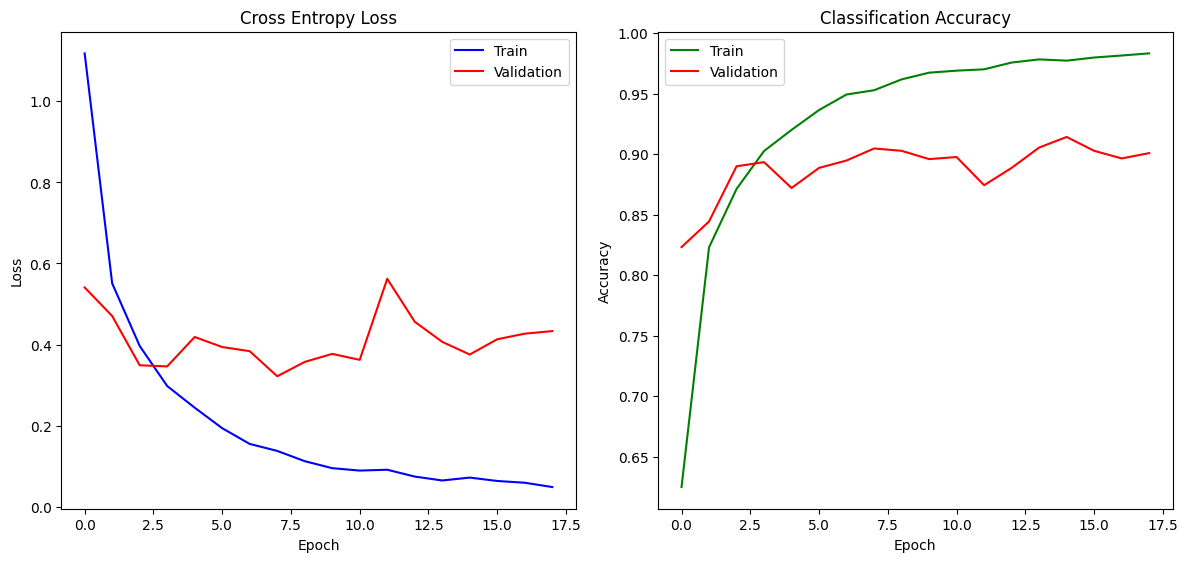

In [ ]:
# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 (Improved Fine-tuning)")
plt.show()

# --- Plotting Training History ---
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history_improved.history['loss'], color='blue', label='Train')
plt.plot(history_improved.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history_improved.history['accuracy'], color='green', label='Train')
plt.plot(history_improved.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
transfer_model.save('model_vgg_3.keras')